# Dependencies

In [1]:
from langchain_community.document_loaders import PyPDFLoader,TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter 
from openai import OpenAI
import requests

from langchain_openai import ChatOpenAI
from langchain.chains import LLMChain
from pinecone import Pinecone, ServerlessSpec
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate


from langchain.agents import initialize_agent, Tool
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.schema import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents import AgentExecutor

from langchain_core.tools import tool
from pydantic.v1 import BaseModel, Field
from openai import OpenAI


from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command

from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END

from pydantic import BaseModel, Field, ValidationError
from typing import List, Union, Dict, Optional
from pinecone import Index

import validators
import requests
import os
import uuid

from dotenv import load_dotenv
load_dotenv()

import os
import sys
import time

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_API_ENV = os.getenv("PINECONE_API_ENV")
PINECONE_QA_BASE_INDEX_NAME = os.getenv("PINECONE_QA_BASE_INDEX_NAME")
PINECONE_KNOWLEDGE_BASE_INDEX_NAME = os.getenv("PINECONE_KNOWLEDGE_BASE_INDEX_NAME")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_community/document_loaders/blob_loaders/file_system.py:5: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.document_loaders.blob_loaders.schema import Blob, BlobLoader
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_community/document_loaders/__init__.py:219: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 i

In [2]:
openAI_client = OpenAI(api_key=OPENAI_API_KEY)
embedding_model = openAI_client.embeddings
pc = Pinecone(api_key = PINECONE_API_KEY, environment = PINECONE_API_ENV)
doc_index = pc.Index(PINECONE_KNOWLEDGE_BASE_INDEX_NAME)
qa_index = pc.Index(PINECONE_QA_BASE_INDEX_NAME)


def get_embedding(text) :
    """
        Function to convert the text string into embeddings using text-embedding-3-small from OpenAI
    
        Args:
            text : A string which will contain either the text chunk or the user query
            
        Returns:
            vector : A vector of 1536 dimensions
    """
    
    try:
        response = embedding_model.create(
            input=text,
            model="text-embedding-3-small"
        )
        
        return response.data[0].embedding   
    
    except Exception as e:
        raise Exception(str(e))
    

# Agents and Tools Setup
Here, we need the worker agents and tools setup for this to work and we will be using the following : 

- Text Knowledge Base Agent
- Q&A Knowledge Base Agent
- Fallback Agent

## Text Knowledge Base Agent

In [3]:
kb_query_prompt_template = """
    \n\n User Query : {query}
    \n\n Documents : {documents}
"""

kb_query_prompt = PromptTemplate(
    input_variables=["query","documents"],
    template= kb_query_prompt_template
)

kb_system_instructions = """
    You are a specialised AI document analyser working at an edtech startup, and you will be assisting the users to answer their queries. You will be given 
    the top relevant documents and you have to use those to answer the query asked by the user, which will be given to you below. 
    
    In the relevant documents,you will be given the cosine similarity score, the document name and the reference (which is the page number where this 
    text was in the document) and the text itself. You can in you answer integrate the document name and reference to build authenticity of your answer, 
    by precisely writing it like (reference page : page_num). You should eventually tell the user to explore more about the topic in the document and that 
    reference page. Infact, this would be highly favourable if you mention the document name and reference to build your authenticity
    
    MAKE SURE YOU DO NOT ANSWER FROM ANYTHING APART FROM THE DOCUMENTS GIVEN TO YOU. 
"""


In [4]:
kb_openAI_client = OpenAI(api_key=OPENAI_API_KEY)
kb_text_assistant_id = os.getenv("KNOWLEDGE_BASE_OPENAI_ASSISTANT_ID")

kb_doc_thread = kb_openAI_client.beta.threads.create()

def kb_fetch_answer(final_prompt):
    kb_openAI_client.beta.threads.messages.create(
        thread_id=kb_doc_thread.id,
        role="user",
        content= [{
            "type" : "text",
            "text" : final_prompt
        }]
    )
            
    run = openAI_client.beta.threads.runs.create(
        thread_id=kb_doc_thread.id,
        assistant_id=kb_text_assistant_id,
    )
    
    while True:
        run = openAI_client.beta.threads.runs.retrieve(
            thread_id=kb_doc_thread.id,
            run_id=run.id
        )
        if run.status == 'completed':
            messages = openAI_client.beta.threads.messages.list(
                thread_id=kb_doc_thread.id
            )
            return messages.data[0].content[0].text.value
        elif run.status in ['failed', 'cancelled', 'expired']:
            raise Exception(f"Run ended with status: {run.status}")
        time.sleep(1)

In [5]:
@tool
def kb_answer_query(query):
    """
        Find relevant documents for a given query and userID.
        
        Args:
        - query: The search query
        
        Returns:
        Final text answer from the LLM, given the relevant documents.
    """
    query_vector = get_embedding(query)
    results = doc_index.query(
        vector=query_vector,
        top_k=5,
        include_values=False,
        include_metadata=True,
        filter={
            "userID": os.getenv("ADMIN_ID")
        }
    )
    
    relevant_texts = []
    for record in results['matches']:
        text = {
            'score': record['score'],
            'text': record['metadata']['chunk'],
            'name': record['metadata']['document_name'],
            'reference': int(record["metadata"]["page_number"]) + 1
        }
        relevant_texts.append(text)
    
    final_prompt = kb_query_prompt.invoke({"query" : query,"documents": relevant_texts}).text
    return kb_fetch_answer(final_prompt)
    

In [6]:
kb_main_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an assistant who can handle queries by using the tool you have and refer the user to correct material, you just have to pass the exact user query to the tool and it will do the rest, If the tool does not give relevant answers, just tell the user that you do not know by giving the response as 'I do not know'...",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

kb_llm = ChatOpenAI(
    api_key = OPENAI_API_KEY,
    model = "gpt-4o",
    temperature=0.2
)

kb_tools = [kb_answer_query]
kb_llm_with_tools = kb_llm.bind_tools(kb_tools)

text_knowledge_base_agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | kb_main_prompt
    | kb_llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

text_knowledge_base_agent_agent_executor = AgentExecutor(agent=text_knowledge_base_agent, tools=kb_tools, verbose=True)
list(text_knowledge_base_agent_agent_executor.stream({"input": "what is meant by rolling up the state?"}))



> Entering new None chain...

Invoking: `kb_answer_query` with `{'query': 'what is meant by rolling up the state?'}`


"Rolling up the state" refers to the practice of lifting state up to a common ancestor component in a React application. As an application grows, multiple components might need access to the same piece of state. Instead of duplicating this state across different components, you can manage it in the least common ancestor (LCA) of these components. This approach helps in avoiding unoptimal re-renders by ensuring that only components that need to know about the state changes are re-rendered (W9-react, reference page: 37).

To explore more about this concept, you can refer to the document "W9-react" on page 37."Rolling up the state" refers to the practice of lifting state up to a common ancestor component in a React application. As an application grows, multiple components might need access to the same piece of state. Instead of duplicating this state across different co

[{'actions': [ToolAgentAction(tool='kb_answer_query', tool_input={'query': 'what is meant by rolling up the state?'}, log="\nInvoking: `kb_answer_query` with `{'query': 'what is meant by rolling up the state?'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_fb6oDw2H9X2Dshatg2e9uTYT', 'function': {'arguments': '{"query":"what is meant by rolling up the state?"}', 'name': 'kb_answer_query'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87'}, id='run-fcccfc5e-908f-442e-86ac-756ae3fcb9f1', tool_calls=[{'name': 'kb_answer_query', 'args': {'query': 'what is meant by rolling up the state?'}, 'id': 'call_fb6oDw2H9X2Dshatg2e9uTYT', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'kb_answer_query', 'args': '{"query":"what is meant by rolling up the state?"}', 'id': 'call_fb6oDw2H9X2Dshatg2e9uTYT', 'index': 0, 'type': 'tool_call_chunk'}])]

## Q&A Knowledge Base Agent

In [7]:
system_instructions_qa = """
    You are a specialised AI context aware doubt solver working at an edtech startup, and you will be assisting the users to answer their queries based on previous intrcutors and TAs solved queries.
    You will be given a query by the user and the top relevant documents and you have to use those to answer the query asked by the user, which will be given to you below. 
    In the relevant documents,you will be given the id of the conversation, the cosine similarity score, the question which was aksed by previous student and the answers by the TAs, along with the id of the QA pair. 
    YOU MUST tell the user that they can explore this further by going to that thread (give them the id) and looking at the entire conversation for better understanding. (Think of this as a reference to build authenticity, as you mention the id).
    
    MAKE SURE YOU DO NOT ANSWER FROM ANYTHING APART FROM THE DOCUMENTS GIVEN TO YOU. 
"""

query_prompt_template_qa = """
    \n\n User Query : {query}
    \n\n Documents : {documents}
"""

query_prompt_qa = PromptTemplate(
    input_variables=["query","documents"],
    template=query_prompt_template_qa
)

In [8]:
qa_assistant_id = os.getenv("QA_OPENAI_ASSISTANT_ID")

qa_thread = openAI_client.beta.threads.create()

def fetch_answer_qa(final_prompt):
    openAI_client.beta.threads.messages.create(
        thread_id=qa_thread.id,
        role="user",
        content= [{
            "type" : "text",
            "text" : final_prompt
        }]
    )
            
    run = openAI_client.beta.threads.runs.create(
        thread_id=qa_thread.id,
        assistant_id=qa_assistant_id,
    )
    
    while True:
        run = openAI_client.beta.threads.runs.retrieve(
            thread_id=qa_thread.id,
            run_id=run.id
        )
        if run.status == 'completed':
            messages = openAI_client.beta.threads.messages.list(
                thread_id=qa_thread.id
            )
            return messages.data[0].content[0].text.value
        elif run.status in ['failed', 'cancelled', 'expired']:
            raise Exception(f"Run ended with status: {run.status}")
        time.sleep(1)

In [9]:
@tool
def answer_query_qa(query):
    """
        Find relevant documents for a given query and userID.
        
        Args:
        - query: The search query
        
        Returns:
        Final text answer from the LLM, given the relevant documents.
    """
    query_vector = get_embedding(query)
    
    results = qa_index.query(
        vector = query_vector,
        top_k = 10,
        include_values = False,
        include_metadata = True,
        filter={
            "ADMIN_ID" : os.getenv('ADMIN_ID_QA'),
        }
    )
    
    relevant_pairs = []
    for record in results['matches']:
        pair = {}
        pair['id'] = record['metadata']['QA_ID']
        pair['score'] = record['score']
        pair['question'] = record['metadata']['question']
        pair['answer'] = record['metadata']['answer']
        relevant_pairs.append(pair)
    
    
    final_prompt = query_prompt_qa.invoke({"query" : query,"documents": relevant_pairs}).text
    return fetch_answer_qa(final_prompt)
    

In [10]:
qa_main_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an assistant who can handle queries by using the tool you have and refer the user to correct question answer pairs, you just have to pass the exact user query to the tool and it will do the rest, and just give them the answer as it has come from the tool. If the tool does not give relevant answers, just tell the user that you do not know by giving the response as 'I do not know' ...",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

qa_llm = ChatOpenAI(
    api_key = OPENAI_API_KEY,
    model = "gpt-4o",
    temperature=0.2
)

qa_tools = [answer_query_qa]
qa_llm_with_tools = qa_llm.bind_tools(qa_tools)


qa_knowledge_base_agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | qa_main_prompt
    | qa_llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

qa_agent_executor = AgentExecutor(agent=qa_knowledge_base_agent, tools=qa_tools, verbose=True)
list(qa_agent_executor.stream({"input": "I was having issues in my NEXTJS project, as I tried to animate the dropdown menu, I got a hydration error."}))



> Entering new None chain...

Invoking: `answer_query_qa` with `{'query': 'hydration error in NEXTJS when animating dropdown menu'}`


To address the hydration error you're experiencing in your Next.js project while animating a dropdown menu, you can follow these steps based on a similar issue resolved in a previous discussion:

1. **Restart the Server**: Sometimes, simply restarting the Next.js server can resolve hydration issues.

2. **Inspect Styles**: Use the browser's inspect element tool to check if Tailwind CSS (or any other CSS framework you're using) is being loaded correctly. If the styles are present but not applied, it might indicate a configuration issue.

3. **Verify Tailwind CSS Setup**: Ensure that Tailwind CSS is set up correctly in your project. This involves checking your Tailwind configuration file to make sure the necessary classes are being generated and applied. Refer to the Tailwind CSS documentation for detailed setup instructions.

For more detailed insights

[{'actions': [ToolAgentAction(tool='answer_query_qa', tool_input={'query': 'hydration error in NEXTJS when animating dropdown menu'}, log="\nInvoking: `answer_query_qa` with `{'query': 'hydration error in NEXTJS when animating dropdown menu'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_VUUTA6T5xKkKIEoBgb14CUIf', 'function': {'arguments': '{"query":"hydration error in NEXTJS when animating dropdown menu"}', 'name': 'answer_query_qa'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4'}, id='run-156dffa9-3b9c-4367-8408-d433913034c0', tool_calls=[{'name': 'answer_query_qa', 'args': {'query': 'hydration error in NEXTJS when animating dropdown menu'}, 'id': 'call_VUUTA6T5xKkKIEoBgb14CUIf', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'answer_query_qa', 'args': '{"query":"hydration error in NEXTJS when animating dropdown menu"}', 

## FallBack Agent

In [11]:
fb_assistant_id = os.getenv("FALLBACK_OPENAI_ASSISTANT_ID")

In [12]:
fb_thread = openAI_client.beta.threads.create()

def fetch_answer_fb(final_prompt):
    openAI_client.beta.threads.messages.create(
        thread_id=fb_thread.id,
        role="user",
        content= [{
            "type" : "text",
            "text" : final_prompt
        }]
    )
            
    run = openAI_client.beta.threads.runs.create(
        thread_id=fb_thread.id,
        assistant_id=fb_assistant_id,
    )
    
    while True:
        run = openAI_client.beta.threads.runs.retrieve(
            thread_id=fb_thread.id,
            run_id=run.id
        )
        if run.status == 'completed':
            messages = openAI_client.beta.threads.messages.list(
                thread_id=fb_thread.id
            )
            return messages.data[0].content[0].text.value
        elif run.status in ['failed', 'cancelled', 'expired']:
            raise Exception(f"Run ended with status: {run.status}")
        time.sleep(1)

In [13]:
@tool
def answer_query_fb(query):
    """
        Find relevant documents for a given query and userID.
        
        Args:
        - query: The search query
        - Admin ID : This is the id of the admin who owns the course/group
        - Course ID : The course id of from which this conversation is from 
        - Topic ID : This will be a fixed list of id's to get easy access and for the TA's to see which topics have the most number of conversations or dounts
        
        Returns:
        Final text answer from the LLM, given the relevant documents.
    """
        
    return fetch_answer_fb(query)
    

In [14]:
fb_main_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an assistant who can handle queries of students, however you are only acitvated in the case they do not understand from the main sources. Hence, YOU MUST TELL AT THE START OF YOUR ANSWER CLEARLY THAT THIS IS AI GENERATED (even a tag like [AI GENERATED] telling the user with a warning will be optimal)...",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

fb_llm = ChatOpenAI(
    api_key = OPENAI_API_KEY,
    model = "gpt-4o",
    temperature=0.5
)

fb_tools = [answer_query_fb]
fb_llm_with_tools = fb_llm.bind_tools(fb_tools)

fb_agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | fb_main_prompt
    | fb_llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

agent_executor_fb = AgentExecutor(agent=fb_agent, tools=fb_tools, verbose=True)
list(agent_executor_fb.stream({"input": "NextJS Auth seems a bit difficult...could you just tell me how it works?"}))



> Entering new None chain...
[AI GENERATED]

Sure! Next.js authentication can seem complex at first, but it's quite manageable once you understand the basics. Here's a high-level overview of how authentication typically works in a Next.js application:

1. **Authentication Libraries**: Next.js doesn't come with a built-in authentication system, but you can use libraries like NextAuth.js or Auth0 to handle authentication. These libraries provide a set of tools and components to manage user authentication and sessions.

2. **Session Management**: When a user logs in, the authentication library creates a session. This session is usually stored in a cookie or local storage. The session contains information about the user and their authentication state.

3. **API Routes**: Next.js provides API routes that can be used to handle authentication requests. For example, you can create routes for login, logout, and registration. These routes can interact with your authentication library to manage

[{'output': "[AI GENERATED]\n\nSure! Next.js authentication can seem complex at first, but it's quite manageable once you understand the basics. Here's a high-level overview of how authentication typically works in a Next.js application:\n\n1. **Authentication Libraries**: Next.js doesn't come with a built-in authentication system, but you can use libraries like NextAuth.js or Auth0 to handle authentication. These libraries provide a set of tools and components to manage user authentication and sessions.\n\n2. **Session Management**: When a user logs in, the authentication library creates a session. This session is usually stored in a cookie or local storage. The session contains information about the user and their authentication state.\n\n3. **API Routes**: Next.js provides API routes that can be used to handle authentication requests. For example, you can create routes for login, logout, and registration. These routes can interact with your authentication library to manage user sess

# LangGraph 
We will be using langgraph, which follows a graph like structure to connect multiple agents and use them as defined in a single request, along with which we can also prioritize the agents based on the importance of the agent in the request. For that, what we would be needing is the supervisor agent, which will be responsible for managing the agents and their priorities.

So here, we would want to have each agent as a member, which performs a specific task and then the supervisor agent, which will be responsible for managing the agents and their priorities. Ideally, the priority of the agents is currently :

1. Resolver
2. Librarian
3. Fallback

In [114]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["resolver", "librarian", "fallback"]
options = members + ["FINISH"]
NextLiteral = Literal["resolver", "librarian", "fallback", "FINISH"]

supervisor_prompt_v1 = """
    You are a supervisor tasked with managing a conversation between the
    following workers: {members}. Given the following user request,
    respond with the worker to act next. Each worker will perform a
    task and respond with their results and status. Ideally, you must
    priotize the workers based on the context of the conversation.
    If the user asks a practical or intial quetion, you should start with "resolver".
    If the user aims for a more in-depth or specific answer, you should go with "librarian".
    If the user asks a complex or odd question, you should use "fallback".
    
    Once you get a response from a worker, you MUST RETURN IT's OUTPUT BACK TO THE USER AND WAIT FOR THE NEXT RESPONSE.
    REMEMBER, YOU ARE SUPPOSE TO CHOOSE THE BEST WORKER AS DEFINED ABOVE AND THEN GIVE A RESPONSE BACK TO THE USER.
    DO NOT RUN MULTIPLE CHAINS AT ONCE, JUST ONE AT A TIME.
    When finished, respond with FINISH.
"""



class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: NextLiteral


llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    model="gpt-4o",
    temperature=0.2
)


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal["resolver", "librarian", "fallback", "__end__"]]:
    supervisor_prompt = supervisor_prompt_v1.format(members=", ".join(members))
    messages = [
        {"role": "system", "content": supervisor_prompt},
    ] + state["messages"]
    
    response = llm.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

# Worker Agent Nodes

In [115]:
def resolver_node(state: State) :
    user_message = state["messages"][-1].content
    agent_input = {"input": user_message}
    
    result = qa_agent_executor.invoke(agent_input)
    output_answer = result["output"]
    
    return {
        "messages": [
            HumanMessage(
                content=output_answer, name="resolver"
            )
        ]
    }
    
def librarian_node(state: State) :
    user_message = state["messages"][-1].content
    agent_input = {"input": user_message}
    
    result = text_knowledge_base_agent_agent_executor.invoke(agent_input)
    output_answer = result["output"]
    
    return {
        "messages": [
            HumanMessage(
                content=output_answer, name="resolver"
            )
        ]
    }
    
def fallback_node(state: State) :
    user_message = state["messages"][-1].content
    agent_input = {"input": user_message}
    
    result = agent_executor_fb.invoke(agent_input)
    output_answer = result["output"]
    
    return {
        "messages": [
            HumanMessage(
                content=output_answer, name="resolver"
            )
        ]
    }

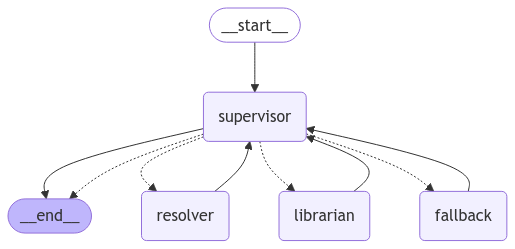

In [117]:
workflow = StateGraph(State)

# Add nodes and edges
workflow.add_edge(START, "supervisor")
workflow.add_node("supervisor", supervisor_node)
workflow.add_node("resolver", resolver_node)
workflow.add_node("librarian", librarian_node)
workflow.add_node("fallback", fallback_node)

workflow.add_edge("resolver","supervisor")
workflow.add_edge("librarian","supervisor")
workflow.add_edge("fallback","supervisor")

workflow.add_edge("supervisor", END)

graph = workflow.compile()
graph

# Simulating the Agent Conversation

In [118]:
initial_state = State(messages=[],next="supervisor")
while True:
    # Display current conversation history
    if "messages" in initial_state and initial_state["messages"]:
        for msg in initial_state["messages"]:
            print(f"{msg['role'].capitalize()}: {msg['content']}")

    # Get user input
    user_input = input("You: ")
    
    # Check for exit condition
    if user_input.lower() in ["exit", "quit"]:
        print("Exiting the conversation. Goodbye!")
        break
    
    # Append the user input to the state
    initial_state["messages"].append({"role": "user", "content": user_input})
    initial_state["input"] = user_input

    # Invoke the graph to process the user input
    try:
        # result = graph.invoke(initial_state)
        result = graph.stream(initial_state)
        print(result)
    except Exception as e:
        print(f"An error occurred: {e}")
        break
    
    # Update state based on the graph response
    if "update" in result:
        initial_state.update(result["update"])
    
    # Check if the conversation has finished
    if result.get("goto") == "__end__":
        print("Supervisor: FINISH")
        break


<generator object Pregel.stream at 0x12ffaa700>


> Entering new AgentExecutor chain...

Invoking: `answer_query_qa` with `{'query': 'NextJS hydration error'}`


If you're dealing with a hydration error in your Next.js project, particularly when animating a dropdown menu, here's a solution based on a similar issue that was resolved previously:

1. **Restart the Server**: Restarting the Next.js server can sometimes resolve hydration issues.

2. **Inspect Styles**: Use the browser's inspect element tool to ensure that Tailwind CSS (or any other CSS framework you're using) is being loaded correctly. If the styles are present but not applied, it might indicate a configuration issue.

3. **Verify Tailwind CSS Setup**: Make sure that Tailwind CSS is set up correctly in your project. This involves checking your Tailwind configuration file to ensure that the necessary classes are being generated and applied. Refer to the Tailwind CSS documentation for detailed setup instructions.

For more det

KeyboardInterrupt: 

In [105]:
initial_state

{'messages': [{'role': 'user',
   'content': 'I am having issues with NextJS hydration error'}],
 'next': 'supervisor',
 'input': 'I am having issues with NextJS hydration error'}